In [1]:
from utils.download_kaggle_dataset import download_kaggle_competition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
import string
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords

# Setup
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
sns.set(style='whitegrid')

[nltk_data] Downloading package stopwords to /Users/navin/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
data = download_kaggle_competition("nlp-getting-started")
print(data)

Unzipping files...
Competition data downloaded to: datasets
datasets


In [4]:
train_df = pd.read_csv(f"{data}/train.csv")
test_df = pd.read_csv(f"{data}/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

Train shape: (7613, 5)
Test shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


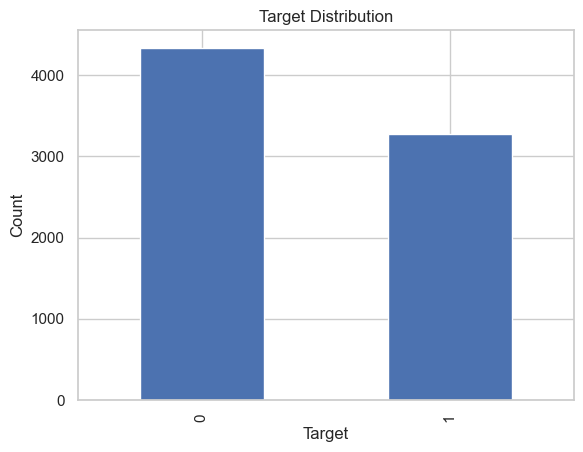

In [5]:
train_df.info()
train_df.describe()
train_df['target'].value_counts().plot(kind='bar', title='Target Distribution', xlabel='Target', ylabel='Count')
plt.show()


Missing values in train set:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


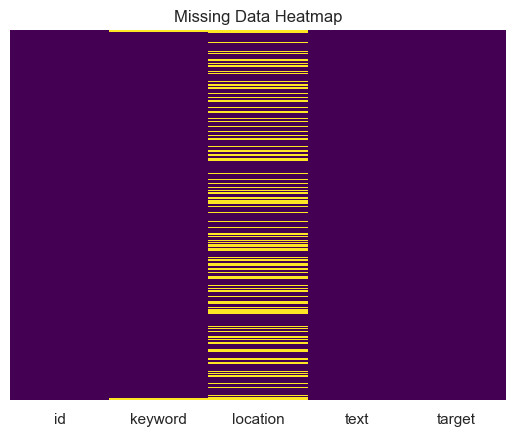

In [6]:
print("Missing values in train set:\n", train_df.isnull().sum())
sns.heatmap(train_df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()


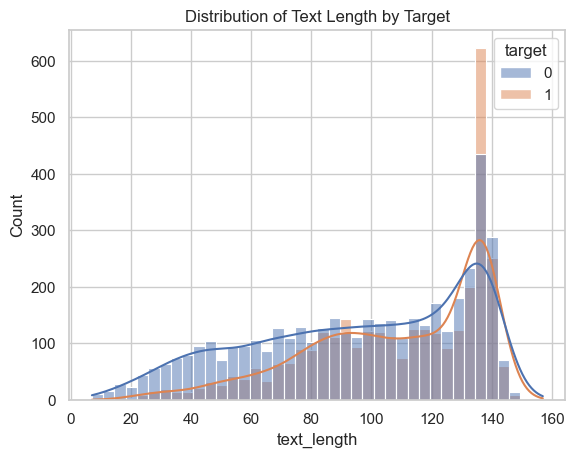

In [7]:
train_df['text_length'] = train_df['text'].apply(len)
sns.histplot(data=train_df, x='text_length', hue='target', bins=40, kde=True)
plt.title("Distribution of Text Length by Target")
plt.show()


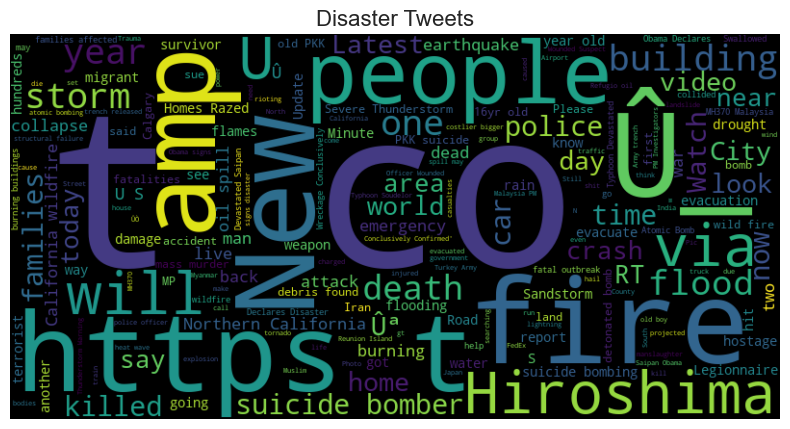

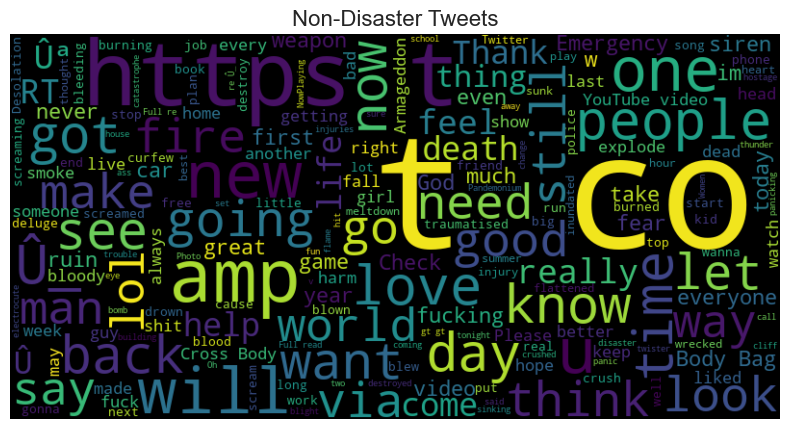

In [8]:
def plot_wordcloud(data, title):
    text = " ".join(data)
    wc = WordCloud(width=800, height=400, max_words=200).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()
plot_wordcloud(train_df[train_df['target']==1]['text'], "Disaster Tweets")
plot_wordcloud(train_df[train_df['target']==0]['text'], "Non-Disaster Tweets")

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)


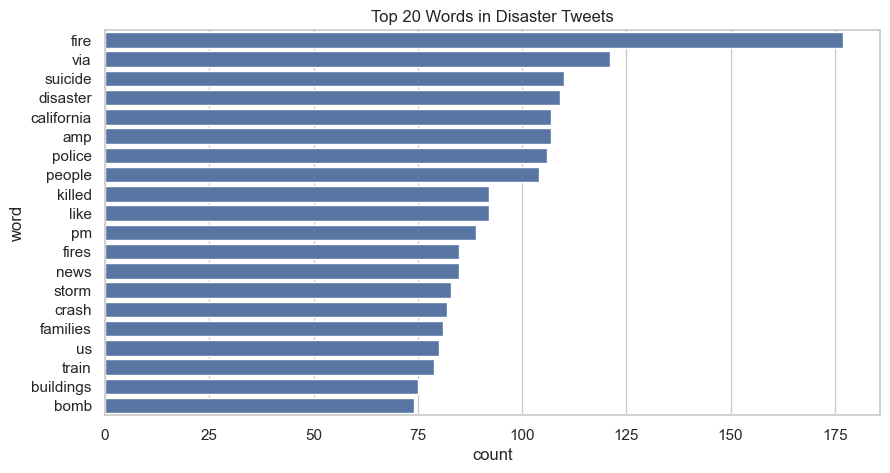

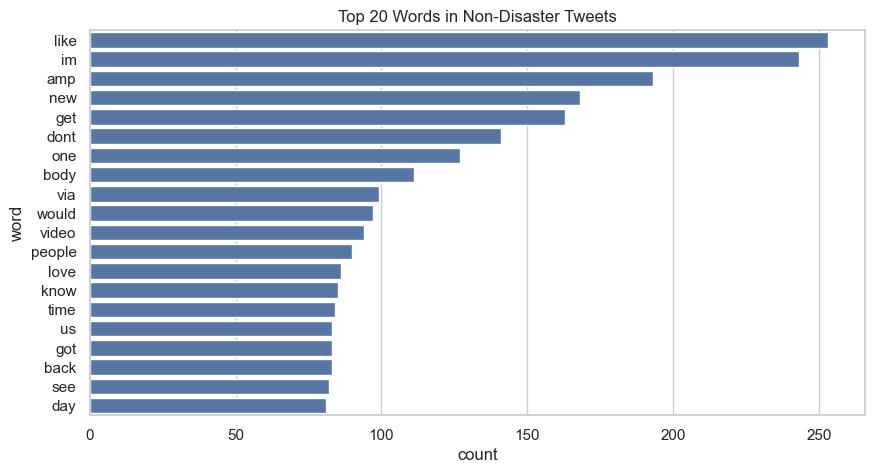

In [11]:
from collections import Counter

def get_top_n_words(corpus, n=None):
    words = [word for sentence in corpus for word in sentence.split()]
    return Counter(words).most_common(n)

common_disaster = get_top_n_words(train_df[train_df['target']==1]['clean_text'], 20)
common_nondisaster = get_top_n_words(train_df[train_df['target']==0]['clean_text'], 20)

def plot_common_words(common_words, title):
    df = pd.DataFrame(common_words, columns=['word', 'count'])
    plt.figure(figsize=(10,5))
    sns.barplot(x='count', y='word', data=df)
    plt.title(title)
    plt.show()

plot_common_words(common_disaster, 'Top 20 Words in Disaster Tweets')
plot_common_words(common_nondisaster, 'Top 20 Words in Non-Disaster Tweets')


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(train_df['clean_text'])
words = vectorizer.get_feature_names_out()

disaster_texts = train_df[train_df['target']==1]['clean_text']
non_disaster_texts = train_df[train_df['target']==0]['clean_text']

disaster_matrix = vectorizer.transform(disaster_texts)
non_disaster_matrix = vectorizer.transform(non_disaster_texts)

disaster_counts = np.array(disaster_matrix.sum(axis=0)).flatten()
non_disaster_counts = np.array(non_disaster_matrix.sum(axis=0)).flatten()

freq_df = pd.DataFrame({'word': words, 'disaster': disaster_counts, 'non_disaster': non_disaster_counts})
freq_df['diff'] = freq_df['disaster'] - freq_df['non_disaster']
freq_df.sort_values(by='diff', ascending=False).head(20)


,word,disaster,non_disaster,diff
825,suicide,110,6,104
119,california,107,5,102
467,killed,92,3,89
292,families,81,6,75
237,disaster,109,35,74
659,pm,89,16,73
661,police,106,33,73
315,fires,85,16,69
407,hiroshima,66,1,65
96,bombing,67,2,65
